# Day 4: GRU Networks

## Learning Objectives
- Understand GRU simplified gating mechanism
- Compare GRU vs LSTM performance
- Implement GRU for financial prediction

---

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

print("✅ Libraries loaded!")
print("📚 Day 4: GRU Networks")

✅ Libraries loaded!
📚 Day 4: GRU Networks


## Part 1: GRU Architecture

GRU simplifies LSTM with 2 gates instead of 3:

**Update Gate**: $z_t = \sigma(W_z \cdot [h_{t-1}, x_t])$

**Reset Gate**: $r_t = \sigma(W_r \cdot [h_{t-1}, x_t])$

**Candidate**: $\tilde{h}_t = \tanh(W \cdot [r_t \odot h_{t-1}, x_t])$

**Update**: $h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t$

In [13]:
# ============================================================
# GRU CELL FROM SCRATCH
# ============================================================

print("GRU CELL IMPLEMENTATION")
print("="*60)

class GRUCell(nn.Module):
    """Single GRU cell for educational purposes."""
    
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Combined weights for reset and update gates
        self.W_xz = nn.Linear(input_size, hidden_size)   # Update gate (input)
        self.W_hz = nn.Linear(hidden_size, hidden_size)  # Update gate (hidden)
        self.W_xr = nn.Linear(input_size, hidden_size)   # Reset gate (input)
        self.W_hr = nn.Linear(hidden_size, hidden_size)  # Reset gate (hidden)
        self.W_xh = nn.Linear(input_size, hidden_size)   # Candidate (input)
        self.W_hh = nn.Linear(hidden_size, hidden_size)  # Candidate (hidden)
        
    def forward(self, x, h_prev):
        # Update gate
        z = torch.sigmoid(self.W_xz(x) + self.W_hz(h_prev))
        
        # Reset gate
        r = torch.sigmoid(self.W_xr(x) + self.W_hr(h_prev))
        
        # Candidate hidden state
        h_tilde = torch.tanh(self.W_xh(x) + self.W_hh(r * h_prev))
        
        # New hidden state
        h = (1 - z) * h_prev + z * h_tilde
        
        return h, {'z': z, 'r': r}

# Test
gru_cell = GRUCell(input_size=3, hidden_size=32)
x = torch.randn(4, 3)
h = torch.zeros(4, 32)
h_new, gates = gru_cell(x, h)

print(f"Input: {x.shape}")
print(f"Hidden: {h_new.shape}")
print(f"Gates: z={gates['z'].shape}, r={gates['r'].shape}")

GRU CELL IMPLEMENTATION
Input: torch.Size([4, 3])
Hidden: torch.Size([4, 32])
Gates: z=torch.Size([4, 32]), r=torch.Size([4, 32])


## Part 2: GRU vs LSTM Comparison

In [15]:
# ============================================================
# PARAMETER COMPARISON
# ============================================================

print("PARAMETER COMPARISON: LSTM vs GRU")
print("="*60)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

# Compare parameters
for hidden_size in [32, 64, 128]:
    lstm = LSTMModel(5, hidden_size)
    gru = GRUModel(5, hidden_size)
    
    lstm_params = sum(p.numel() for p in lstm.parameters())
    gru_params = sum(p.numel() for p in gru.parameters())
    
    print(f"\nHidden size {hidden_size}:")
    print(f"  LSTM: {lstm_params:,} params")
    print(f"  GRU:  {gru_params:,} params")
    print(f"  GRU saves: {(lstm_params - gru_params) / lstm_params * 100:.1f}%")

PARAMETER COMPARISON: LSTM vs GRU

Hidden size 32:
  LSTM: 13,473 params
  GRU:  10,113 params
  GRU saves: 24.9%

Hidden size 64:
  LSTM: 51,521 params
  GRU:  38,657 params
  GRU saves: 25.0%

Hidden size 128:
  LSTM: 201,345 params
  GRU:  151,041 params
  GRU saves: 25.0%


In [16]:
# ============================================================
# PREPARE DATA
# ============================================================

print("\nPREPARING DATA")
print("="*60)

# Generate returns
np.random.seed(42)
n_days = 1000
returns = np.random.normal(0.0002, 0.015, n_days)

# Add some autocorrelation
for i in range(1, len(returns)):
    returns[i] += 0.1 * returns[i-1]

# Features
df = pd.DataFrame({'returns': returns})
df['vol_5d'] = df['returns'].rolling(5).std()
df['vol_20d'] = df['returns'].rolling(20).std()
df['mom_5d'] = df['returns'].rolling(5).mean()
df['mom_20d'] = df['returns'].rolling(20).mean()
df = df.dropna()

features = df.values
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Create sequences
seq_len = 20
X, y = [], []
for i in range(len(features) - seq_len):
    X.append(features[i:i+seq_len])
    y.append(features[i+seq_len, 0])

X, y = np.array(X), np.array(y)

split = int(len(X) * 0.8)
X_train, X_test = torch.FloatTensor(X[:split]), torch.FloatTensor(X[split:])
y_train, y_test = torch.FloatTensor(y[:split]).unsqueeze(1), torch.FloatTensor(y[split:]).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

print(f"Training: {X_train.shape}")
print(f"Test: {X_test.shape}")


PREPARING DATA
Training: torch.Size([768, 20, 5])
Test: torch.Size([193, 20, 5])


In [17]:
# ============================================================
# TRAIN AND COMPARE
# ============================================================

print("TRAINING COMPARISON")
print("="*60)

def train_model(model, name, epochs=100):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    history = []
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        for X_b, y_b in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(X_b), y_b)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            test_loss = criterion(model(X_test), y_test).item()
        history.append(test_loss)
    
    train_time = time.time() - start_time
    return history, train_time

# Train both
lstm = LSTMModel(5, 64, 2)
gru = GRUModel(5, 64, 2)

print("Training LSTM...")
lstm_history, lstm_time = train_model(lstm, "LSTM")
print(f"  Done in {lstm_time:.1f}s")

print("Training GRU...")
gru_history, gru_time = train_model(gru, "GRU")
print(f"  Done in {gru_time:.1f}s")

# Evaluate
lstm.eval()
gru.eval()

with torch.no_grad():
    lstm_preds = lstm(X_test).numpy().flatten()
    gru_preds = gru(X_test).numpy().flatten()
    actuals = y_test.numpy().flatten()

lstm_dir_acc = np.mean(np.sign(lstm_preds) == np.sign(actuals))
gru_dir_acc = np.mean(np.sign(gru_preds) == np.sign(actuals))

print(f"\n{'Metric':<20} {'LSTM':>10} {'GRU':>10}")
print("-" * 42)
print(f"{'Parameters':<20} {sum(p.numel() for p in lstm.parameters()):>10,} {sum(p.numel() for p in gru.parameters()):>10,}")
print(f"{'Training Time (s)':<20} {lstm_time:>10.1f} {gru_time:>10.1f}")
print(f"{'Final Test Loss':<20} {lstm_history[-1]:>10.6f} {gru_history[-1]:>10.6f}")
print(f"{'Direction Accuracy':<20} {lstm_dir_acc*100:>9.1f}% {gru_dir_acc*100:>9.1f}%")

TRAINING COMPARISON
Training LSTM...
  Done in 12.6s
Training GRU...
  Done in 11.4s

Metric                     LSTM        GRU
------------------------------------------
Parameters               51,521     38,657
Training Time (s)          12.6       11.4
Final Test Loss        4.561645   6.124547
Direction Accuracy        46.1%      48.2%


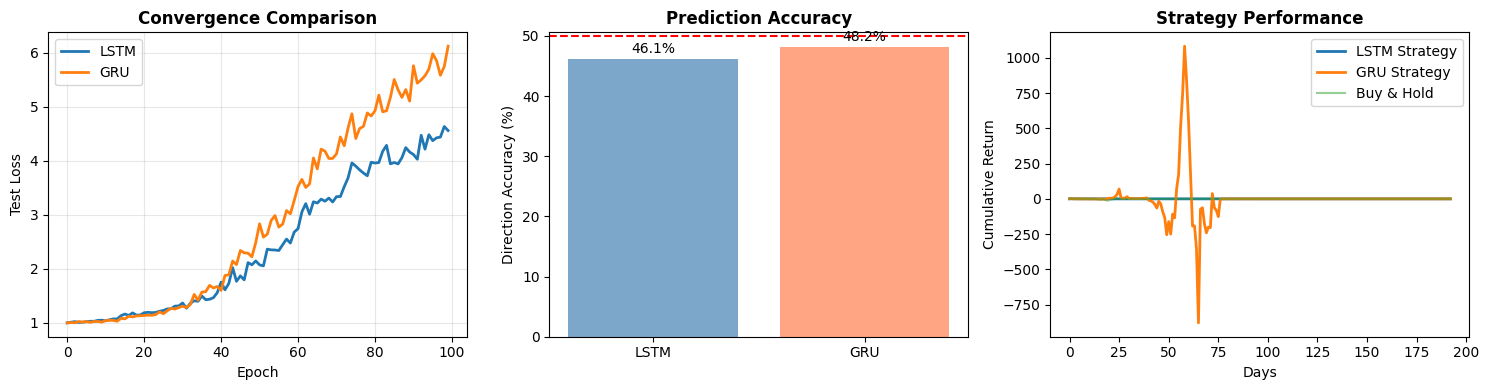

In [18]:
# ============================================================
# VISUALIZE COMPARISON
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Learning curves
axes[0].plot(lstm_history, label='LSTM', linewidth=2)
axes[0].plot(gru_history, label='GRU', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Test Loss')
axes[0].set_title('Convergence Comparison', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Direction accuracy
bars = axes[1].bar(['LSTM', 'GRU'], [lstm_dir_acc*100, gru_dir_acc*100],
                   color=['steelblue', 'coral'], alpha=0.7)
axes[1].axhline(50, color='red', linestyle='--', label='Random')
axes[1].set_ylabel('Direction Accuracy (%)')
axes[1].set_title('Prediction Accuracy', fontweight='bold')
for bar, acc in zip(bars, [lstm_dir_acc, gru_dir_acc]):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{acc*100:.1f}%', ha='center')

# Strategy comparison
lstm_strategy = np.cumprod(1 + actuals * np.sign(lstm_preds))
gru_strategy = np.cumprod(1 + actuals * np.sign(gru_preds))
market = np.cumprod(1 + actuals)

axes[2].plot(lstm_strategy, label='LSTM Strategy', linewidth=2)
axes[2].plot(gru_strategy, label='GRU Strategy', linewidth=2)
axes[2].plot(market, label='Buy & Hold', alpha=0.5)
axes[2].set_xlabel('Days')
axes[2].set_ylabel('Cumulative Return')
axes[2].set_title('Strategy Performance', fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.show()

In [19]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║               DAY 4 COMPLETE: GRU NETWORKS                       ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ GRU simplified gating (2 gates vs 3)                         ║
║  ✓ ~25% fewer parameters than LSTM                              ║
║  ✓ Comparable performance on most tasks                         ║
║  ✓ Faster training time                                         ║
╚══════════════════════════════════════════════════════════════════╝

Tomorrow: Day 5 - Bidirectional & Stacked Architectures
""")


╔══════════════════════════════════════════════════════════════════╗
║               DAY 4 COMPLETE: GRU NETWORKS                       ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ GRU simplified gating (2 gates vs 3)                         ║
║  ✓ ~25% fewer parameters than LSTM                              ║
║  ✓ Comparable performance on most tasks                         ║
║  ✓ Faster training time                                         ║
╚══════════════════════════════════════════════════════════════════╝

Tomorrow: Day 5 - Bidirectional & Stacked Architectures

